<a href="https://colab.research.google.com/github/Emiroji/Neural-network-estimation-of-vocal-function/blob/main/NN_for_estiamte_Vocal_fucntion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pathlib
import time
import math
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import tensorflow as tf
from sklearn.metrics import r2_score
from tensorflow import keras
from tensorflow.keras import layers



In [2]:
#Load min-max of data synthetic used in training
train_stats =pd.read_csv('train_stats.csv')
train_stats.rename(index={0: 'ACFL', 1: 'MFDR', 2: 'OQ_mean', 3: 'sQ_mean', 4: 'f0', 5: 'H1H2', 6: 'spl'},inplace=True)
labels_train_stats =pd.read_csv('labels_train_stats.csv')
labels_train_stats.rename(index={0: 'Ps', 1: 'Pc', 2: 'a_TA', 3: 'a_CT', 4: 'a_LCA'},inplace=True)

In [3]:
train_stats

,count,mean,std,min,25%,50%,75%,max
ACFL,13670.0,0.222810,0.158044,0.031627,0.092293,0.186705,0.315160,0.873012
MFDR,13670.0,299.139137,217.922121,18.302006,118.106273,245.164485,431.093094,1269.082377
OQ_mean,13670.0,78.068842,12.811183,27.121212,68.775601,78.672986,88.786502,99.938950
sQ_mean,13670.0,180.969513,69.456986,66.514768,131.971412,159.774332,212.704634,570.335145
f0,13670.0,226.298086,60.745916,120.000000,180.045965,228.497409,264.864865,400.000000
H1H2,13670.0,12.932274,3.787937,-0.000000,10.726359,12.837125,15.156984,43.258566
spl,13670.0,86.429461,8.458992,56.499185,80.008122,87.673412,93.513522,102.961534


In [4]:
labels_train_stats

,count,mean,std,min,25%,50%,75%,max
Ps,13670.0,866.048805,399.975450,-93.441165,550.863163,861.896587,1215.167607,1589.332036
Pc,13670.0,1417.188981,843.175149,56.104421,741.372754,1265.798641,1866.292056,3999.892730
a_TA,13670.0,0.573431,0.258245,0.000000,0.400000,0.600000,0.800000,1.000000
a_CT,13670.0,0.556394,0.269401,0.000000,0.300000,0.500000,0.800000,1.000000
a_LCA,13670.0,0.528061,0.189017,0.200000,0.400000,0.500000,0.700000,0.800000


In [5]:
#Load Infield Data
filename='InField_Data_feature_control_NPVH_W'
InField_Data_feature=pd.read_csv(filename + ".csv")

InField_Data_feature


,acflow,mfdr,oq,sq,h1h2,naq,freq,cppall,spl_15cm,isSinging,file_id,subject_id,week
0,575.245314,747.274658,81.578947,181.818182,11.327020,0.226744,292.052980,19.437655,84.975638,1.0,NF023_20140108_01_IBIF.mat,NF023,W1
1,520.729631,696.123730,78.378378,190.000000,9.780783,0.222733,297.972973,21.255754,83.893267,1.0,NF023_20140108_01_IBIF.mat,NF023,W1
2,479.823194,637.637739,83.333333,172.727273,11.609908,0.230982,306.250000,18.425145,83.048218,1.0,NF023_20140108_01_IBIF.mat,NF023,W1
3,435.341464,594.636128,90.000000,190.909091,12.022054,0.232790,317.266187,19.677210,82.200606,1.0,NF023_20140108_01_IBIF.mat,NF023,W1
4,396.851816,551.478456,88.571429,205.000000,11.208119,0.230588,319.565217,19.884673,81.513256,1.0,NF023_20140108_01_IBIF.mat,NF023,W1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3253777,245.153482,285.964838,85.526316,225.000000,1.080650,0.125187,146.026490,28.050726,69.301493,0.0,NF069_20130105_02_IBIF.mat,NF069,W1
3253778,234.492561,259.983872,86.666667,124.137931,1.434176,0.133035,147.491639,27.354673,68.978663,0.0,NF069_20130105_02_IBIF.mat,NF069,W1
3253779,242.674929,253.182691,89.189189,144.444444,1.976377,0.143787,150.000000,26.711964,68.047045,0.0,NF069_20130105_02_IBIF.mat,NF069,W1
3253780,296.376099,260.888708,62.711864,146.666667,10.997256,0.215102,186.075949,17.047845,72.942727,0.0,NF069_20130105_02_IBIF.mat,NF069,W1


In [6]:
#Select data for Week 1 and read file name
InField_Data_feature=InField_Data_feature[InField_Data_feature['week']=='W1']
file_name=InField_Data_feature.file_id.unique()

In [7]:
#Define NN architecture
Neurons=4
def build_model():
  model = keras.Sequential([
    layers.Dense(Neurons, activation='relu', input_shape=[5]),
    layers.Dropout(0.1),
    layers.Dense(Neurons, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(5)
  ])

  optimizer = tf.keras.optimizers.Adam(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [8]:
# Normalization function
def norm(x):
  return (x - train_stats['min']) / (train_stats['max']- train_stats['min'] )

def norm_labels(x):
  return (x - labels_train_stats['min']) / (labels_train_stats['max']- labels_train_stats['min'] )
      

In [9]:
# Construct and load the trained NN
model = build_model()
model = keras.models.load_model('model_7F_2HL4N_5O.h5')
model.summary()                                 

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_27 (Dense)            (None, 4)                 32        
                                                                 
 dropout_18 (Dropout)        (None, 4)                 0         
                                                                 
 dense_28 (Dense)            (None, 4)                 20        
                                                                 
 dropout_19 (Dropout)        (None, 4)                 0         
                                                                 
 dense_29 (Dense)            (None, 5)                 25        
                                                                 
Total params: 77
Trainable params: 77
Non-trainable params: 0
_________________________________________________________________


In [10]:
# Obtain PS, Pc, A_TA, A-CT, A_LCA.
first=1
for file in file_name:
  print(file)
  InField_Data_feature_subject=InField_Data_feature[(InField_Data_feature['file_id']==file)]
  ClinicData =  pd.DataFrame(InField_Data_feature_subject, columns=['acflow','mfdr','oq','sq', 'freq','h1h2', 'spl_15cm'])
  ClinicData = ClinicData.rename(columns = {'acflow': 'ACFL', 'mfdr': 'MFDR', 'oq': 'OQ_mean', 'sq': 'sQ_mean', 'freq': 'f0', 'h1h2': 'H1H2', 'spl_15cm': 'spl'}, inplace = False)
  ClinicData['ACFL']=ClinicData['ACFL']/1000  #from mL/s --> L/s
  ClinicData['spl']=ClinicData['spl']-20*math.log(0.1/0.15,10)  # SPL from 15 cm of the mouth to 10cm of the mouth
  clinic_test_data=ClinicData
  
  normed_clinic_test_data = norm(clinic_test_data)
  clinic_test_predictions_1 = model.predict(normed_clinic_test_data)

  NN_Prediction_norm = pd.DataFrame(clinic_test_predictions_1, columns = ['Ps','Pc','a_TA','a_CT','a_LCA'])
  NN_Prediction_norm['Ps']=NN_Prediction_norm['Ps']*(labels_train_stats['max'][0]- labels_train_stats['min'][0] ) + labels_train_stats['min'][0]
  NN_Prediction_norm['Pc']=NN_Prediction_norm['Pc']*(labels_train_stats['max'][1]- labels_train_stats['min'][1] ) + labels_train_stats['min'][1]
  NN_Prediction_norm['a_TA']=NN_Prediction_norm['a_TA']*(labels_train_stats['max'][2]- labels_train_stats['min'][2] ) + labels_train_stats['min'][2]
  NN_Prediction_norm['a_CT']=NN_Prediction_norm['a_CT']*(labels_train_stats['max'][3]- labels_train_stats['min'][3] ) + labels_train_stats['min'][3]
  NN_Prediction_norm['a_LCA']=NN_Prediction_norm['a_LCA']*(labels_train_stats['max'][4]- labels_train_stats['min'][4] ) + labels_train_stats['min'][4]
  Data_InField_NN=InField_Data_feature_subject.reset_index(drop=True).join(NN_Prediction_norm)
 
  if first==1:
    Data_InField_NN_all=Data_InField_NN
    first=0
  else:
    Data_InField_NN_all=Data_InField_NN_all.append(Data_InField_NN)


NF023_20140108_01_IBIF.mat
NF023_20140107_01_IBIF.mat
NF023_20140106_01_IBIF.mat
NF023_20140105_02_IBIF.mat
NF023_20140105_01_IBIF.mat
NF023_20140104_01_IBIF.mat
NF023_20140103_01_IBIF.mat
NF023_20140102_01_IBIF.mat
NF023_20140101_03_IBIF.mat
NF023_20140101_01_IBIF.mat
NF027_20120110_02_IBIF.mat
NF027_20120110_01_IBIF.mat
NF027_20120109_02_IBIF.mat
NF027_20120109_01_IBIF.mat
NF027_20120108_02_IBIF.mat
NF027_20120108_01_IBIF.mat
NF027_20120107_01_IBIF.mat
NF027_20120106_01_IBIF.mat
NF027_20120103_02_IBIF.mat
NF027_20120103_01_IBIF.mat
NF027_20120102_05_IBIF.mat
NF027_20120102_04_IBIF.mat
NF027_20120102_01_IBIF.mat
NF027_20120101_03_IBIF.mat
NF027_20120101_02_IBIF.mat
NF037_20130122_01_IBIF.mat
NF037_20130121_01_IBIF.mat
NF037_20130120_01_IBIF.mat
NF037_20130119_01_IBIF.mat
NF037_20130109_01_IBIF.mat
NF037_20130108_02_IBIF.mat
NF037_20130108_01_IBIF.mat
NF037_20130107_01_IBIF.mat
NF037_20130101_01_IBIF.mat
NF040_20130108_01_IBIF.mat
NF040_20130107_01_IBIF.mat
NF040_20130106_01_IBIF.mat
N

In [12]:
#Delete outlier 
Data_InField_NN= Data_InField_NN.loc[(Data_InField_NN["a_TA"] >0) & (Data_InField_NN["a_TA"] <1) & (Data_InField_NN["a_CT"] >0) & (Data_InField_NN["a_CT"] <1)  & (Data_InField_NN["a_LCA"] >0) & (Data_InField_NN["a_LCA"] <1)  ]

#Save Results
Data_InField_NN_all.to_csv(filename + "_NN_results.csv")

Data_InField_NN

,acflow,mfdr,oq,sq,h1h2,naq,freq,cppall,spl_15cm,isSinging,file_id,subject_id,week,Ps,Pc,a_TA,a_CT,a_LCA
0,118.898652,47.168265,98.461538,82.857143,20.025923,0.424060,168.965517,15.604206,54.423191,0.0,NF069_20130105_02_IBIF.mat,NF069,W1,384.234100,680.980347,0.537711,0.334052,0.449430
1,81.148951,47.427367,94.202899,130.000000,25.344268,0.305833,159.205776,13.778402,46.211648,0.0,NF069_20130105_02_IBIF.mat,NF069,W1,335.064026,720.493835,0.498889,0.341314,0.411728
2,85.892150,84.054670,83.783784,135.714286,22.038519,0.309613,297.972973,17.319383,54.564402,1.0,NF069_20130105_02_IBIF.mat,NF069,W1,490.504700,909.503174,0.515724,0.418647,0.457496
3,64.679369,63.180443,82.051282,128.571429,19.582587,0.291680,286.363636,14.056494,50.506791,1.0,NF069_20130105_02_IBIF.mat,NF069,W1,436.000122,795.032471,0.526078,0.376133,0.452720
4,81.460041,75.582045,84.210526,121.428571,22.137700,0.309321,290.131579,18.145428,54.188503,1.0,NF069_20130105_02_IBIF.mat,NF069,W1,482.054871,879.105591,0.521597,0.408014,0.459714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11454,277.464440,317.333168,77.631579,247.058824,0.037005,0.127270,145.544554,29.596501,71.265803,0.0,NF069_20130105_02_IBIF.mat,NF069,W1,524.665344,745.391907,0.588794,0.369942,0.515651
11455,245.153482,285.964838,85.526316,225.000000,1.080650,0.125187,146.026490,28.050726,69.301493,0.0,NF069_20130105_02_IBIF.mat,NF069,W1,488.797302,688.358643,0.589436,0.347811,0.508228
11456,234.492561,259.983872,86.666667,124.137931,1.434176,0.133035,147.491639,27.354673,68.978663,0.0,NF069_20130105_02_IBIF.mat,NF069,W1,546.592407,780.257690,0.588402,0.383472,0.520189
11457,242.674929,253.182691,89.189189,144.444444,1.976377,0.143787,150.000000,26.711964,68.047045,0.0,NF069_20130105_02_IBIF.mat,NF069,W1,520.841003,739.310852,0.588862,0.367583,0.514860


Text(0.5, 1.0, 'aLCA')

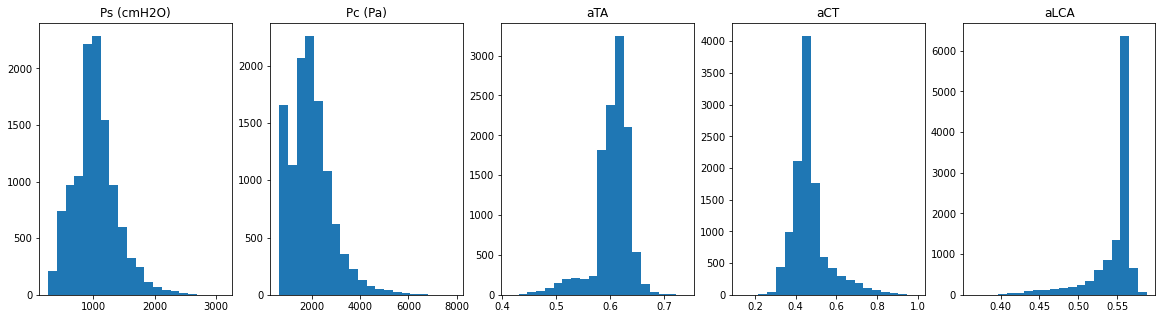

In [13]:
# Plot histogram of NN outputs
fig, axs = plt.subplots(1, 5)
fig.set_size_inches(20, 5)
bins=20;

axs[0].hist(Data_InField_NN["Ps"],bins)
axs[0].set_title('Ps (cmH2O)') 

axs[1].hist(Data_InField_NN["Pc"],bins)
axs[1].set_title('Pc (Pa)') 

axs[2].hist(Data_InField_NN["a_TA"],bins)
axs[2].set_title('aTA') 

axs[3].hist(Data_InField_NN["a_CT"],bins)
axs[3].set_title('aCT') 

axs[4].hist(Data_InField_NN["a_LCA"],bins)
axs[4].set_title('aLCA') 

